In [1]:
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils.func import (get_pictures, apply_hough_transformation, group_lines, draw_line_group, 
                        generate_similar_color_pairs, load_config, create_reference_court, 
                        warp_points)
from utils.lines import Line
from utils.point import Point
from utils.schemas import TestConfig
from utils.court_finder import CourtFinder

from PIL import Image

mpl.rcParams['image.cmap'] = 'gray'

#### helper functions

In [2]:
def display_image(img: np.ndarray) -> None:
    plt.imshow(img)
    plt.show()

def plot_on_image(img: np.ndarray, 
                  lines: list[Line] | None = None, 
                  points: list[Point] | None = None, 
                  is_copy: bool = True,
                  line_color: tuple[int, int, int] = (255, 0, 0),
                  point_color: tuple[int, int, int] = (255, 0, 0)) -> np.ndarray:
    img_copy = img.copy() if is_copy else img

    if lines is not None:
        for line in lines:
            endpoints = line.limit_to_img(img_copy)
            cv2.line(img_copy, *endpoints, line_color)

    if points is not None:
        for point in points:
            cv2.circle(img_copy, point, 3, point_color, -1)

    return img_copy

In [3]:
config = load_config('../config/test.config.json', TestConfig)
param = config.data[0]

#### reading images

In [4]:
train_pic = get_pictures('../data/test')['rgb'][0]

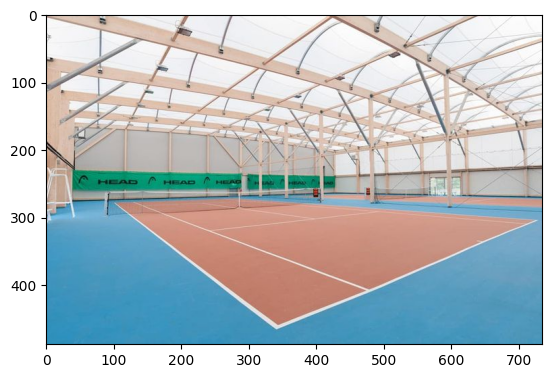

In [5]:
display_image(train_pic)

#### step 1 - image preprocessing

##### computing hough transformation line endpoints

In [6]:
train_pic_hough_lines, line_endpoints = apply_hough_transformation(train_pic)

##### drawing line segments bounded by endpoints from hough transformation

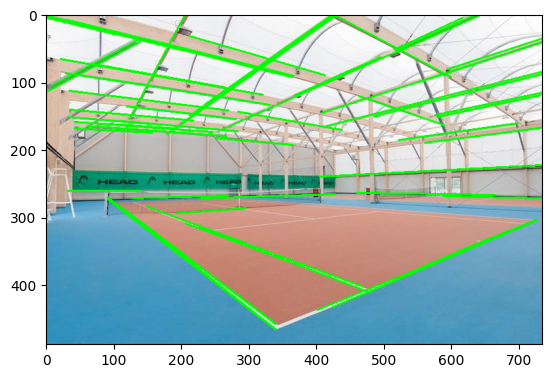

In [7]:
display_image(train_pic_hough_lines)

In [8]:
# Image.fromarray(train_pic_hough_lines).save('../assets/preprocessing1.png')

##### computing lines from hough transformation endpoints (line segments)

In [9]:
line_objs = [Line.from_hough_line(line[0]) for line in line_endpoints]

##### drawing computed lines

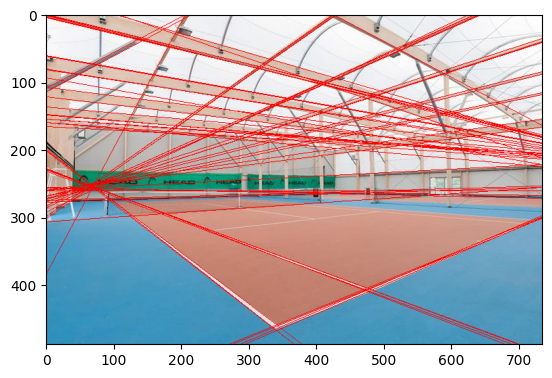

In [10]:
train_pic_lines = plot_on_image(train_pic, lines=line_objs)
display_image(train_pic_lines)

In [11]:
# Image.fromarray(train_pic_lines).save('../assets/pre2_lines_computing.png')

##### lines grouping and drawing it

In [12]:
grouped_lines = group_lines(line_objs, 5, 10)

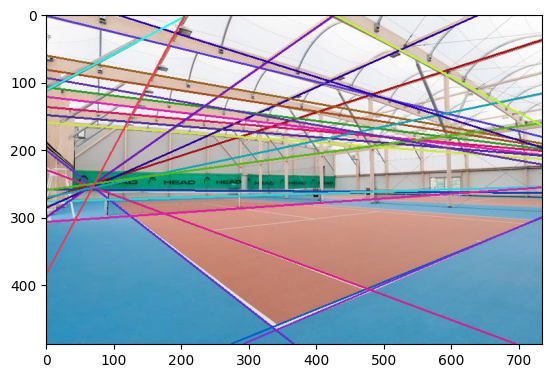

In [13]:
colors = generate_similar_color_pairs(len(grouped_lines))
train_pic_grouped_lines = train_pic.copy()

for color, group in zip(colors, grouped_lines):
    train_pic_grouped_lines = draw_line_group(train_pic_grouped_lines, group, *color)

display_image(train_pic_grouped_lines)

In [14]:
# Image.fromarray(train_pic_grouped_lines).save('../assets/pre3_lines_grouping.png')

##### find group lines intersections

In [15]:
train_pic_line_intersections = train_pic.copy()
intersections = []
for group1 in grouped_lines:
    for group2 in grouped_lines:
        intersection = group1.intersection(group2, train_pic_line_intersections)
        if intersection is not None:
            intersections.append(intersection)

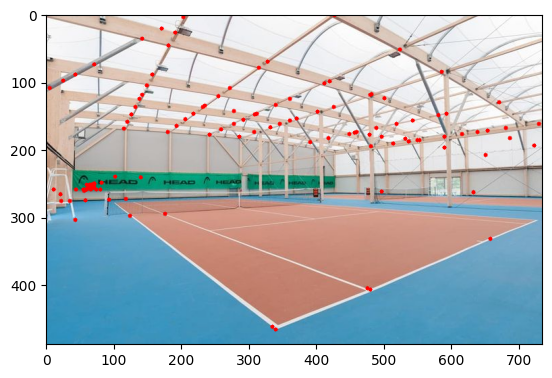

In [16]:
train_pic_line_intersections = plot_on_image(train_pic_line_intersections, points=[inter.point for inter in intersections])
display_image(train_pic_line_intersections)

In [17]:
# Image.fromarray(train_pic_line_intersections).save('../assets/pre4_intersections.png')

##### single intersection with attached lines

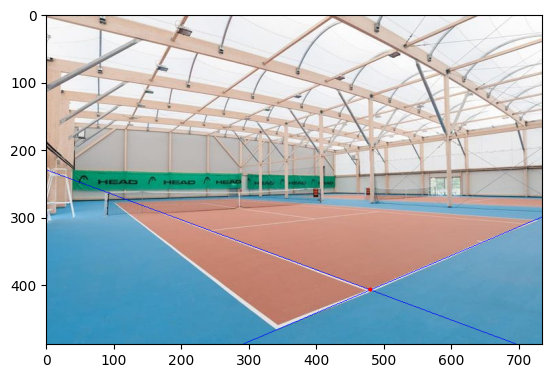

In [18]:
train_pic_single_intersection = train_pic.copy()

intersection = intersections[154]

train_pic_single_intersection = plot_on_image(train_pic_single_intersection, 
                                              lines=[intersection.line1, intersection.line2], 
                                              points=[intersection.point],
                                              line_color=(0, 0, 255))
display_image(train_pic_single_intersection)

In [19]:
# Image.fromarray(train_pic_single_intersection).save('../assets/pre4_intersection_example.png')

#### step 2

In [20]:
court_finder = CourtFinder(intersections, train_pic)

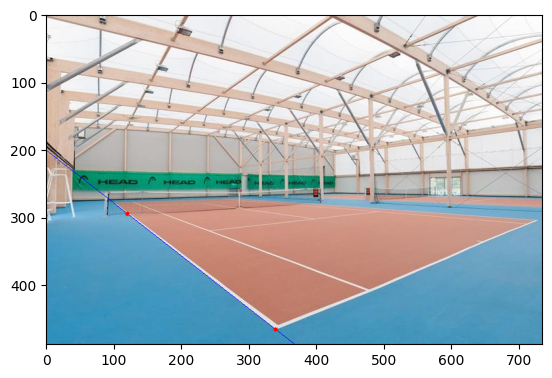

In [21]:
closer_outer_baseline_intersecetion, closer_outer_netintersection, used_line = (
    court_finder.find_closer_outer_baseline_point()
)
closer_outer_baseline_point = closer_outer_baseline_intersecetion.point
closer_outer_netline_point = closer_outer_netintersection.point

closer_outer_sideline = Line.from_points(closer_outer_baseline_point, closer_outer_netline_point)

pic = train_pic.copy()
pic = plot_on_image(pic, 
                    lines=[closer_outer_sideline], 
                    points=[closer_outer_netline_point, closer_outer_baseline_point],
                    line_color=(0, 0, 255))
display_image(pic)

In [22]:
# Image.fromarray(pic).save('../assets/step2.png')

#### step 3

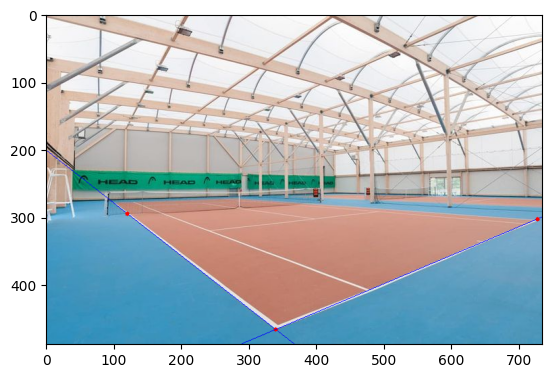

In [23]:
further_outer_baseline_intersection, last_local_line = court_finder.find_further_outer_baseline_intersection(
    closer_outer_baseline_intersecetion,
    used_line,
    param.canny_thresh.lower,
    param.canny_thresh.upper,
    offset=param.offset,
)
further_outer_baseline_point = further_outer_baseline_intersection.point

baseline = Line.from_points(closer_outer_baseline_point, further_outer_baseline_point)
pic = plot_on_image(pic, 
                    lines=[baseline], 
                    points=[further_outer_baseline_point],
                    line_color=(0, 0, 255))
display_image(pic)

In [24]:
# Image.fromarray(pic).save('../assets/step3.png')

#### step 4

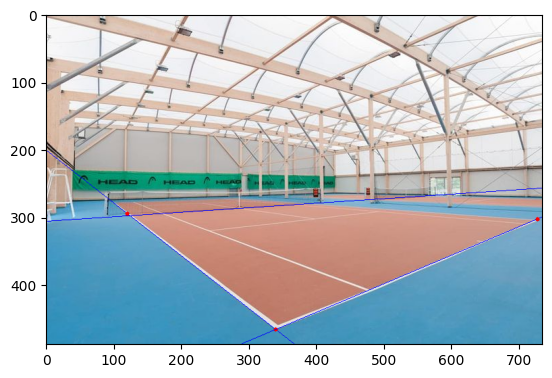

In [25]:
netline = court_finder.find_netline(closer_outer_netline_point, baseline, param.max_line_gap)
pic = plot_on_image(pic, 
                    lines=[netline], 
                    line_color=(0, 0, 255))
display_image(pic)

In [26]:
# Image.fromarray(pic).save('../assets/step4.png')

#### step 5

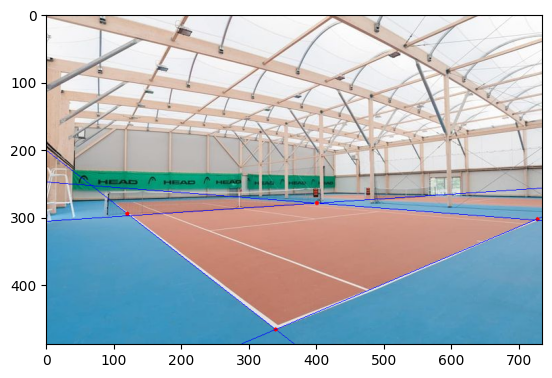

In [27]:
further_outer_sideline = court_finder.find_further_outer_sideline(
    further_outer_baseline_point,
    last_local_line,
    param.offset,
    param.extra_offset,
    param.bin_thresh,
    param.surface_type,
)

further_outer_netline_point = further_outer_sideline.intersection(netline, pic).point
pic = plot_on_image(pic, 
                    lines=[further_outer_sideline],
                    points=[further_outer_netline_point],
                    line_color=(0, 0, 255))
display_image(pic)

In [28]:
# Image.fromarray(pic).save('../assets/step5.png')

#### steps 6a and 6b

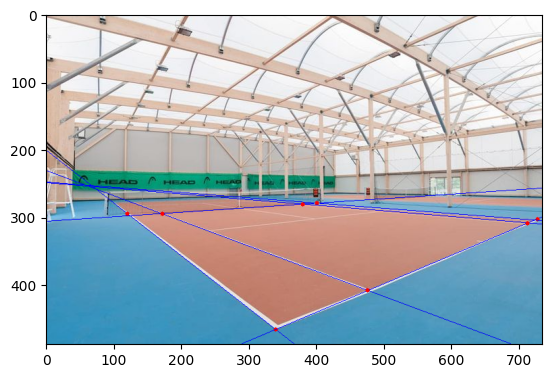

In [29]:
closer_inner_baseline_point, further_inner_baseline_point = court_finder.scan_endline(
    baseline,
    netline,
    closer_outer_baseline_point,
    further_outer_netline_point,
    closer_outer_netline_point,
    further_outer_baseline_point,
    param.bin_thresh_endline_scan.baseline,
    param.canny_thresh.lower,
    param.canny_thresh.upper,
    param.max_line_gap,
    searching_line="base",
)

closer_inner_netline_point, further_inner_netline_point = court_finder.scan_endline(
    baseline,
    netline,
    closer_outer_baseline_point,
    further_outer_netline_point,
    closer_outer_netline_point,
    further_outer_baseline_point,
    param.bin_thresh_endline_scan.netline,
    param.canny_thresh.lower,
    param.canny_thresh.upper,
    param.max_line_gap,
    searching_line="net",
)

closer_inner_sideline = Line.from_points(closer_inner_baseline_point, closer_inner_netline_point)
further_inner_sideline = Line.from_points(further_inner_baseline_point, further_inner_netline_point)

pic = plot_on_image(pic, 
                    lines=[closer_inner_sideline, further_inner_sideline],
                    points=[closer_inner_baseline_point, further_inner_baseline_point, closer_inner_netline_point, further_inner_netline_point],
                    line_color=(0, 0, 255))
display_image(pic)

In [30]:
# Image.fromarray(pic).save('../assets/step6.png')

#### step 7

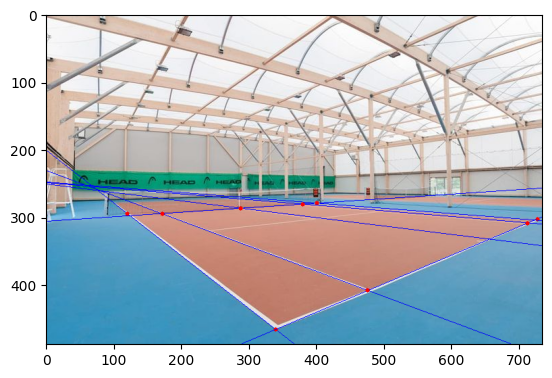

In [31]:
net_service_point, centre_service_line = court_finder.find_net_service_point_centre_service_line(
    closer_outer_baseline_point,
    closer_outer_netline_point,
    further_outer_baseline_point,
    further_outer_netline_point,
    closer_inner_baseline_point,
    further_inner_baseline_point,
    closer_inner_netline_point,
    further_inner_netline_point,
    baseline,
    netline,
    param.bin_thresh_centre_service_line,
    param.canny_thresh.lower,
    param.canny_thresh.upper,
    param.max_line_gap_centre_service_line,
    param.min_line_len_ratio,
    param.hough_thresh,
)

pic = plot_on_image(pic, 
                    lines=[centre_service_line],
                    points=[net_service_point],
                    line_color=(0, 0, 255))
display_image(pic)

In [32]:
# Image.fromarray(pic).save('../assets/step7.png')

#### step 8

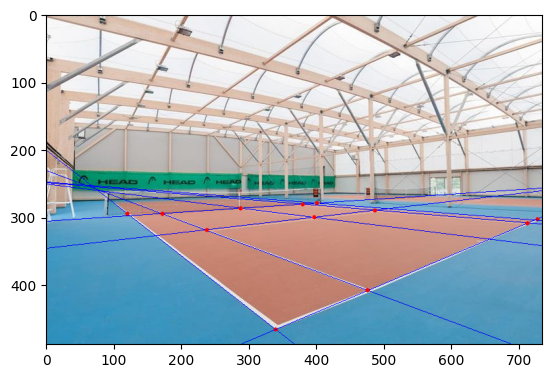

In [33]:
centre_service_point, further_service_point, closer_service_point = court_finder.find_center(
    closer_outer_baseline_point,
    closer_outer_netline_point,
    further_outer_baseline_point,
    further_outer_netline_point,
    closer_inner_baseline_point,
    further_inner_baseline_point,
    closer_inner_netline_point,
    further_inner_netline_point,
    baseline,
    closer_inner_sideline,
    further_inner_sideline,
    centre_service_line,
    param.bin_thresh_centre_service_line,
    param.canny_thresh.lower,
    param.canny_thresh.upper,
    param.max_line_gap_centre_service_line,
    param.min_line_len_ratio,
    param.hough_thresh,
)

service_line = Line.from_points(further_service_point, closer_service_point)
pic = plot_on_image(pic, 
                    lines=[service_line],
                    points=[centre_service_point, further_service_point, closer_service_point],
                    line_color=(0, 0, 255))
display_image(pic)

In [34]:
# Image.fromarray(pic).save('../assets/step8.png')

#### perspective transform

In [35]:
ref_points, ref_img = create_reference_court(line_thickness=200)

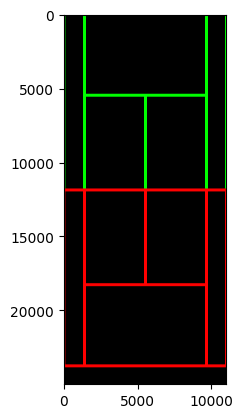

In [36]:
display_image(ref_img)

In [37]:
# Image.fromarray(ref_img).save('../assets/ref_img.png')

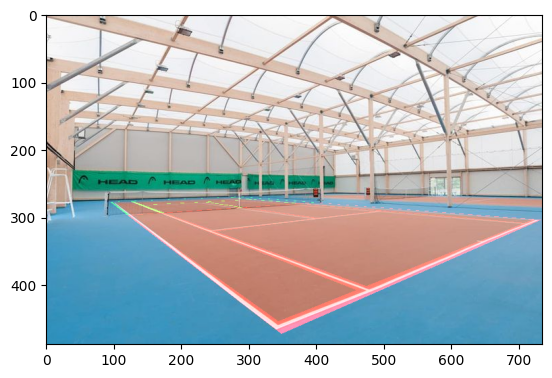

In [38]:
dst_points = {
    "closer_outer_baseline_point": closer_outer_baseline_point,
    "closer_outer_netline_point": closer_outer_netline_point,
    "further_outer_baseline_point": further_outer_baseline_point,
    "further_outer_netline_point": further_outer_netline_point,
    "closer_inner_baseline_point": closer_inner_baseline_point,
    "further_inner_baseline_point": further_inner_baseline_point,
    "closer_inner_netline_point": closer_inner_netline_point,
    "further_inner_netline_point": further_inner_netline_point,
    "net_service_point": net_service_point,
    "centre_service_point": centre_service_point,
    "further_service_point": further_service_point,
    "closer_service_point": closer_service_point,
}

pts = ["closer_outer_baseline_point",
            "closer_inner_baseline_point",
            "further_inner_baseline_point",
            "further_outer_baseline_point",
            "further_outer_netline_point",
            "net_service_point",
            "closer_inner_netline_point",
            "closer_outer_netline_point",]

_, _, covered_img = warp_points(ref_points, dst_points, train_pic, ref_img, *pts)


display_image(covered_img)

In [ ]:
# Image.fromarray(covered_img).save('../assets/projected_points.png')